# 1 Define the Problem
    What is the input data?
    What type of problem? Multiclass singlelabel classification

# 2 Choosing a measure of success
    Accuracy?
    Precision and recall?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import tensorflow as tf
import keras
from keras import models, layers, regularizers, optimizers

from keras.datasets import cifar10

# load data from library
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'{X_train.shape[0]} train samples')
print(f'{X_test.shape[0]} test samples')

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [3]:
# examine data in first sample with label
print(f'first sample:\n{X_train[0][0][:5]}\n...\n')
print(f'first label: {y_train[0]}')

first sample:
[[59 62 63]
 [43 46 45]
 [50 48 43]
 [68 54 42]
 [98 73 52]]
...

first label: [6]


In [4]:
# mapping of label to names
target_names={
    0:"airplane",
    1:"automobile",
    2:"bird",
    3:"cat",
    4:"deer",
    5:"dog",
    6:"frog",
    7:"horse",
    8:"ship",
    9:"truck"}

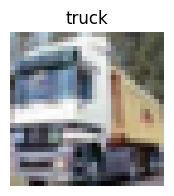

In [5]:
# plot single image sample from data set
def plot_sample(sample=X_train[0], label=6):
    data = sample

    # set plot parameters
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.title(target_names[label])

    # Use imshow to plot pixels
    plt.imshow(data)

    # Display the plot
    plt.show()


plot_sample(X_train[1], y_train[1][0])

12 sample plot


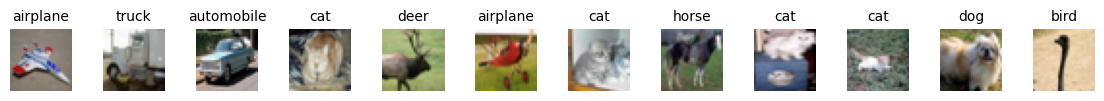

In [6]:
# plot multiple images from cifar10 dataset as subplots
def plot_multi_sample(samples=X_train[0:8], labels=[6,9,9,4,1,1,2,7], pred_labels=None):
    length = len(samples)

    # create horizontal figure with subplots
    fig, axes = plt.subplots(1, length, figsize=(14,8))
    axes = axes.flatten()

    # create subplot for each image data
    for i in range(length):
        data = samples[i]
        label = labels[i]

        # plot parameters
        plt.subplot(1, length, i+1)    
        plt.axis('off')
        
        if pred_labels is not None: 
            plt.title(f'True: {target_names[labels[i]]}\nPred: {target_names[pred_labels[i]]}',
            fontsize=10)
        else:
            plt.title(target_names[labels[i]], 
            fontsize=10)
        plt.subplots_adjust(wspace=0.5)
        plt.imshow(samples[i])
    
    # display sample count and show plot    
    print(f'{length} sample plot')
    plt.show()

plot_multi_sample(X_train[30:42], [y[0] for y in y_train[30:42]])

# 3 Deciding on an Evaluation Protocol
    Hold-out? Our dataset is sufficiently big and well balanced
    K-fold? 

In [7]:
from sklearn.model_selection import train_test_split

# split into validation data and partial training data
# stratify=y_train to ensure even porportion of split labels
x_partial, x_val, y_partial, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=2, stratify=y_train)

print(x_partial.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

40000 train samples
10000 validation samples
10000 test samples


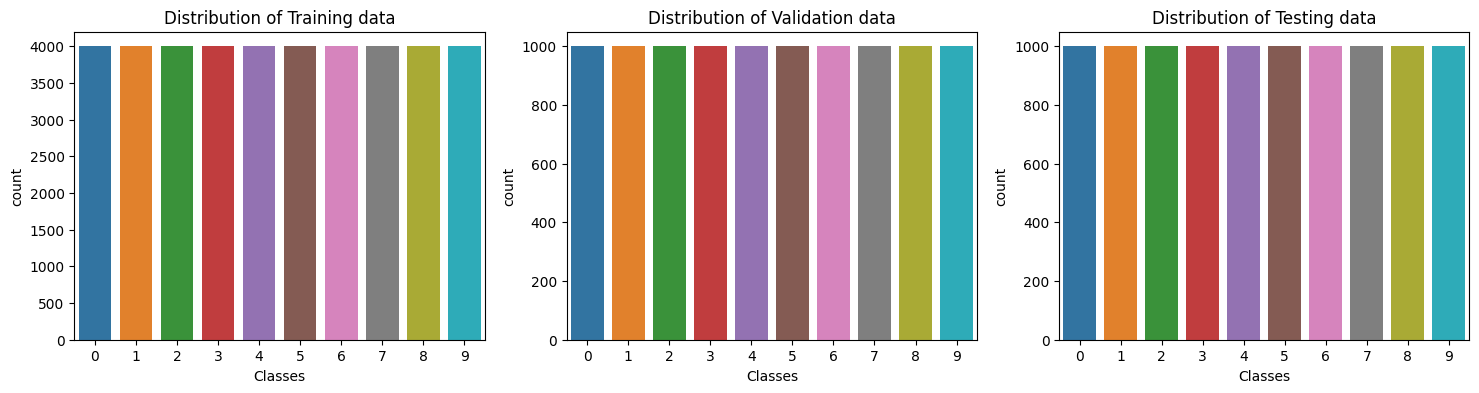

In [8]:
# show distribution of samples by countplot

fig, axes = plt.subplots(1,3,figsize=(18,4)) 
# plot for training set
sns.countplot(x=y_partial.ravel(), ax=axes[0])
axes[0].set_title('Distribution of Training data')
axes[0].set_xlabel('Classes')

# plot for validation set
sns.countplot(x=y_val.ravel(), ax=axes[1])
axes[1].set_title('Distribution of Validation data')
axes[1].set_xlabel('Classes')

# plot for testing set
sns.countplot(x=y_test.ravel(), ax=axes[2])
axes[2].set_title('Distribution of Testing data')
axes[2].set_xlabel('Classes')
plt.show()

# 4 Preparing your data
    Manipulate into tensors
    Normalize values [0, 1]
    Data visualization is not necessary

In [9]:
# from tensorflow.keras.utils import to_categorical

"""
preprocess data, normalize range to [0,1]
"""
def prep_normalize(data):
    data = data.astype('float32') / 255
    return data

"""
one-hot encode integer label data to categorical
"""
def prep_encoder(data, classes=10):
    data = tf.keras.utils.to_categorical(
        data, num_classes=classes, dtype='float32'
    )
    return data

In [10]:
# normalize samples
x_partial = prep_normalize(x_partial)
x_val = prep_normalize(x_val)
x_test = prep_normalize(X_test)

# one-hot encode labels
y_partial = prep_encoder(y_partial)
y_val = prep_encoder(y_val)

y_test = y_test.ravel()

print(x_partial)
print(y_partial)

[[[[0.44705883 0.72156864 0.8509804 ]
   [0.4392157  0.70980394 0.8392157 ]
   [0.44313726 0.70980394 0.8392157 ]
   ...
   [0.4392157  0.7019608  0.84313726]
   [0.43529412 0.7019608  0.84313726]
   [0.43529412 0.7058824  0.84313726]]

  [[0.44705883 0.72156864 0.84705883]
   [0.4392157  0.70980394 0.8352941 ]
   [0.44313726 0.70980394 0.8352941 ]
   ...
   [0.43137255 0.69803923 0.83137256]
   [0.43137255 0.7019608  0.83137256]
   [0.43529412 0.70980394 0.8392157 ]]

  [[0.45490196 0.73333335 0.84705883]
   [0.44313726 0.7176471  0.827451  ]
   [0.44313726 0.7137255  0.827451  ]
   ...
   [0.43137255 0.7019608  0.83137256]
   [0.43137255 0.7019608  0.83137256]
   [0.43137255 0.70980394 0.83137256]]

  ...

  [[0.8784314  0.78039217 0.6039216 ]
   [0.83137256 0.7372549  0.5647059 ]
   [0.8235294  0.7294118  0.5568628 ]
   ...
   [0.8666667  0.74509805 0.5372549 ]
   [0.8392157  0.7176471  0.5058824 ]
   [0.84705883 0.73333335 0.52156866]]

  [[0.8392157  0.7411765  0.5686275 ]
   [0.8

In [11]:
# helper functions

"""
function to plot model history
"""
def plot_history(history, name='Model'): 
    fig, axes = plt.subplots(1,2,figsize=(12,4)) 
    # plot training & valid loss
    axes[0].plot(history.history['loss']) 
    axes[0].plot(history.history['val_loss']) 
    axes[0].set_title(f'{name} Loss History')
    axes[0].set_ylabel('Loss') 
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Training', 'Validation'])
    # axes[0].legend(['Training', 'Validation'], loc='upper left')
    
    # plot training & valid accuracy
    axes[1].plot(history.history['accuracy']) 
    axes[1].plot(history.history['val_accuracy']) 
    axes[1].set_title(f'{name} Accuracy History')
    axes[1].set_ylabel('Accuracy') 
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Training', 'Validation'])
    plt.show()


# loss and accuracy with testing set
def evaluate_model(model):
    loss, acc = model.evaluate(x_test, prep_encoder(y_test), verbose=1)
    print(f'Test loss: {loss}')
    print(f'Test accu: {acc}')
    return loss, acc


# optimal epoch
def optimal_epoch(history):
    min_loss = np.argmin(history.history['val_loss'])
    max_accu = np.argmax(history.history["val_accuracy"])
    print(f'Min loss at epoch: {min_loss}')
    print(f'Max accu at epoch: {max_accu}')
    return min_loss, max_accu

In [ ]:

"""
moving average
stackoverflow.com/questions/20618804/how-to-smooth-a-curve-for-a-dataset#answer-26337730
"""
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


"""
plot multiple history graphs for comparing rate differences
"""
def plot_history_comparison(histories, legend_names, title, lim=None, dotted=None):
    fig, axes = plt.subplots(1,2,figsize=(12,4)) 
    # plot training & valid loss for multiple models
    for i, history in enumerate(histories):
        # truncate and smooth data before plotting
        data = smooth(history.history['val_loss'],10)
        if lim: data = data[:lim]
        if dotted and i+1 in dotted: 
            axes[0].plot(data, linestyle='dotted') 
        else: 
            axes[0].plot(data) 
    axes[0].set_title(f'{title} Validation Loss Comparison')
    axes[0].set_ylabel('Loss') 
    axes[0].set_xlabel('Epoch')
    axes[0].legend(legend_names)

    # plot training & valid accuracy
    for i, history in enumerate(histories):
        # truncade and smooth data before plotting
        data = smooth(history.history['val_accuracy'],10)
        if lim: data = data[:lim]
        if dotted and i+1 in dotted: 
            axes[1].plot(data, linestyle='dotted') 
        else: 
            axes[1].plot(data) 
    axes[1].set_title(f'{title} Validation Accuracy Comparison')
    axes[1].set_ylabel('Accuracy') 
    axes[1].set_xlabel('Epoch')
    axes[1].legend(legend_names)
    plt.show()

# 5 Developing a model that does better than a baseline
    Aim for statistical power
    State the common-sense baseline: 10%
    Last layer? softmax
    Loss Function? crossentropy
    Optimizer? RMSProp

- multiclass single label dataset, use crossentropy for loss
- this is classification, so we'll use accuracy as the metric
- for now use rmsprop as the optimizer

- image classification, for the sake of baseline comparisons, we'll start with a dense layer and compare with convolution layers later
- it will be as large as the input shape

In [19]:
"""
baseline two layer dense model width:32
"""
def dense_baseline_model():
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape=X_train[0].shape))
    model.add(layers.Flatten()) # flatten dimensions before output
    model.add(layers.Dense(10, activation='softmax'))
    
    # hyperparameters
    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

model = dense_baseline_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32, 32, 32)        128       
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                327690    
                                                                 
Total params: 327,818
Trainable params: 327,818
Non-trainable params: 0
_________________________________________________________________


In [20]:
N_EPOCHS = 100
BATCH_SIZE = 32


history = model.fit(x_partial, y_partial,
                    validation_data=(x_val, y_val),
                    epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                    verbose=1)

Epoch 1/100
1250/1250 [==============================] - 16s 12ms/step - loss: 1.7474 - accuracy: 0.4010 - val_loss: 1.5999 - val_accuracy: 0.4397
Epoch 2/100
1250/1250 [==============================] - 16s 13ms/step - loss: 1.5426 - accuracy: 0.4700 - val_loss: 1.5684 - val_accuracy: 0.4612
Epoch 3/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.4864 - accuracy: 0.4912 - val_loss: 1.5445 - val_accuracy: 0.4667
Epoch 4/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.4480 - accuracy: 0.5025 - val_loss: 1.5255 - val_accuracy: 0.4801
Epoch 5/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.4198 - accuracy: 0.5152 - val_loss: 1.5365 - val_accuracy: 0.4726
Epoch 6/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.3954 - accuracy: 0.5268 - val_loss: 1.5369 - val_accuracy: 0.4735
Epoch 7/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.3782 - accuracy: 0.5328 - val_loss: 1

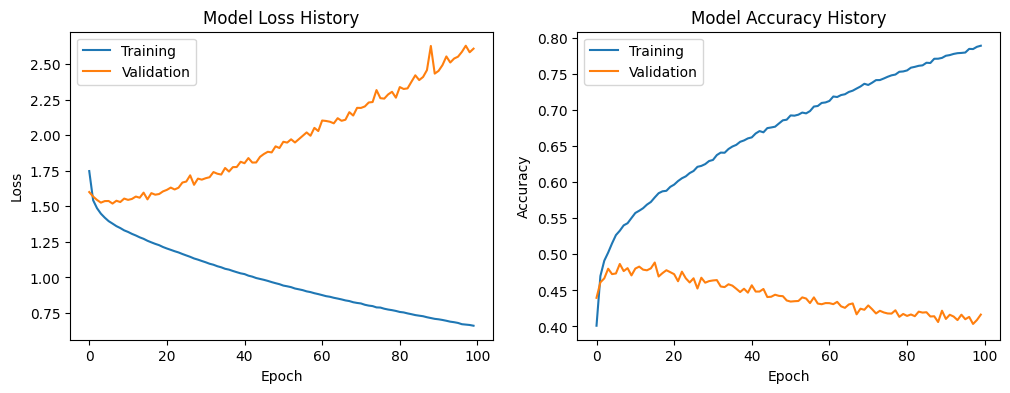

In [21]:
plot_history(history)

In [24]:
# loss and accuracy with testing set
evaluate_model(model)

# optimal epoch
optimal_epoch(history)

313/313 [==============================] - 3s 8ms/step - loss: 2.5588 - accuracy: 0.4122
Test loss: 2.5587668418884277
Test accu: 0.41220003366470337
Min loss at epoch: 6
Max accu at epoch: 15


(6, 15)

Number of correct predictions: 4122/10000
Prediction accuracy: 0.4122
10 sample plot


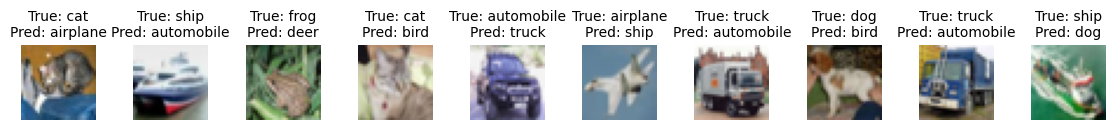

In [25]:
# use trained model to predict testing data, same as model.evaluate()
y_pred = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

# get index count of false predictions
errors = np.sum(y_pred != y_test)
errors_index = np.where(y_pred != y_test)[0]
test_samples = len(y_pred)

print(f'Number of correct predictions: {test_samples-errors}/{test_samples}')
print(f'Prediction accuracy: {1-errors/test_samples}')

# plot incorrect preditions, true vs predicted labels
plot_multi_sample(X_test[errors_index][:10], y_test[errors_index][:10].ravel(), y_pred[errors_index][:10])

convolutional architecture

# 6 Scaling up - Developing a model that overfits
    From statistical power to sufficient power
    Increase model capacity, +layers, layersize
    Monitor overfitting and validation loss and other metrics
    Demonstrate graphically and in text overfitting

- a common convolutional architecture to increase depth is grouping 'blocks' of two conv2d and one maxpooling
- it removes the variance filter size, using only 3x3 stride 2 
- depth of each sequential block doubles
- first introduced in vgg16

In [35]:
"""
two block model following vgg16
"""
def conv2d_model(blocks=1, optimizer='rmsprop', layer_size=1, padding='valid'):
    model = models.Sequential()

    # block 1
    model.add(layers.Conv2D(32 * layer_size, (3, 3), 
                            activation='relu',
                            padding=padding,
                            input_shape=X_train[0].shape))
    model.add(layers.Conv2D(32 * layer_size, (3, 3), activation='relu', padding=padding))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # block 2
    if blocks>1:
        model.add(layers.Conv2D(64 * layer_size, (3, 3), activation='relu', padding=padding))
        model.add(layers.Conv2D(64 * layer_size, (3, 3), activation='relu', padding=padding))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # block 3
    if blocks>2:
        model.add(layers.Conv2D(128 * layer_size, (3, 3), activation='relu', padding=padding))
        model.add(layers.Conv2D(128 * layer_size, (3, 3), activation='relu', padding=padding))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # head output
    model.add(layers.Flatten())
    model.add(layers.Dense(64 * np.power(2,blocks-1) * layer_size))
    model.add(layers.Dense(10, activation='softmax'))
    
    # hyperparameters
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# model_c = conv2d_model(blocks=2, dropout=0.25)
# model_c.summary()

In [27]:
# model 'a' with one convolutional block
model_a = conv2d_model(blocks=1)
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                401472    
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                      

In [28]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_a = model_a.fit(x_partial, y_partial,
                      validation_data=(x_val, y_val),
                      epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                      verbose=1)

Epoch 1/100
313/313 [==============================] - 7s 17ms/step - loss: 1.6594 - accuracy: 0.4100 - val_loss: 1.4893 - val_accuracy: 0.4801
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 1.2892 - accuracy: 0.5491 - val_loss: 1.2073 - val_accuracy: 0.5776
Epoch 3/100
313/313 [==============================] - 5s 15ms/step - loss: 1.1245 - accuracy: 0.6059 - val_loss: 1.1004 - val_accuracy: 0.6176
Epoch 4/100
313/313 [==============================] - 5s 16ms/step - loss: 1.0133 - accuracy: 0.6480 - val_loss: 1.1666 - val_accuracy: 0.5922
Epoch 5/100
313/313 [==============================] - 5s 15ms/step - loss: 0.9281 - accuracy: 0.6762 - val_loss: 1.1163 - val_accuracy: 0.6174
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 0.8568 - accuracy: 0.7018 - val_loss: 1.0422 - val_accuracy: 0.6432
Epoch 7/100
313/313 [==============================] - 5s 16ms/step - loss: 0.7874 - accuracy: 0.7267 - val_loss: 1.1130 - val_accuracy:

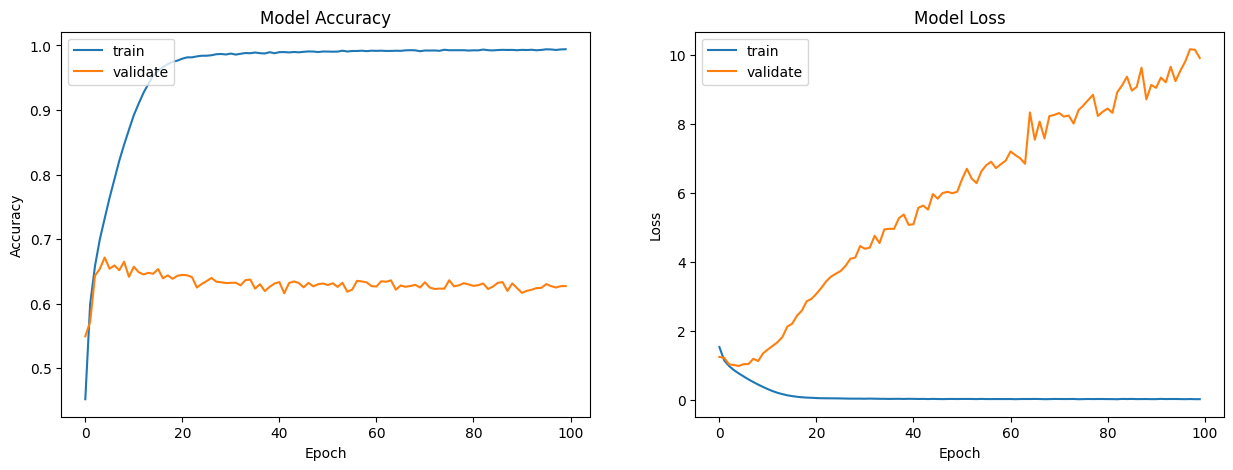

In [22]:
plot_history(history_a, 'model_a')

In [38]:
# evaluate loss and accuracy with testing set
evaluate_model(model_a)

# print optimal epoch from training history
optimal_epoch(history_a)

313/313 [==============================] - 3s 8ms/step - loss: 7.3295 - accuracy: 0.6259
Test loss: 7.329469680786133
Test accu: 0.6259000301361084
Min loss at epoch: 7
Max accu at epoch: 11


(7, 11)

In [36]:
# model 'b' with two convolutional block depth
model_b = conv2d_model(blocks=2)
model_b.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_69 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_71 (Conv2D)          (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                

In [31]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_b = model_b.fit(x_partial, y_partial,
                      validation_data=(x_val, y_val),
                      epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                      verbose=1)

Epoch 1/100
313/313 [==============================] - 8s 19ms/step - loss: 1.8074 - accuracy: 0.3493 - val_loss: 2.2466 - val_accuracy: 0.3220
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 1.3956 - accuracy: 0.5014 - val_loss: 1.3134 - val_accuracy: 0.5292
Epoch 3/100
313/313 [==============================] - 5s 17ms/step - loss: 1.1766 - accuracy: 0.5851 - val_loss: 1.0745 - val_accuracy: 0.6273
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 1.0205 - accuracy: 0.6416 - val_loss: 0.9845 - val_accuracy: 0.6587
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 0.9023 - accuracy: 0.6861 - val_loss: 0.9424 - val_accuracy: 0.6709
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 0.8005 - accuracy: 0.7211 - val_loss: 0.9197 - val_accuracy: 0.6823
Epoch 7/100
313/313 [==============================] - 6s 20ms/step - loss: 0.7178 - accuracy: 0.7510 - val_loss: 0.9813 - val_accuracy:

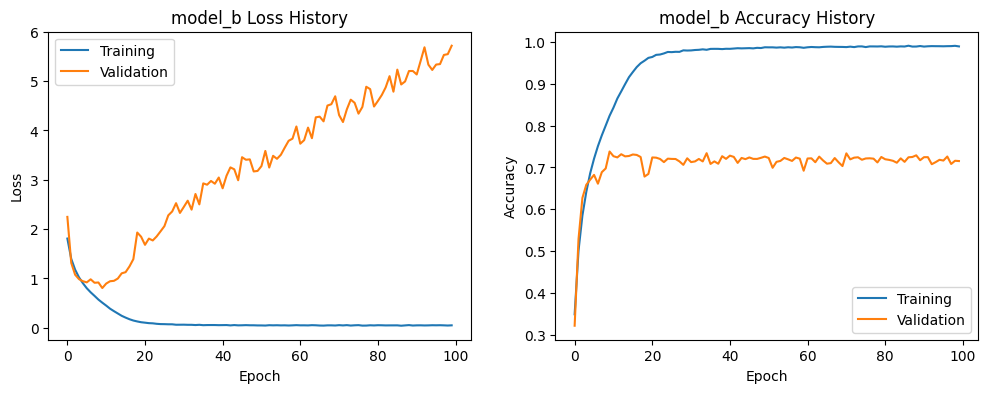

In [32]:
plot_history(history_b, 'model_b')

In [33]:
# evaluate loss and accuracy with testing set
evaluate_model(model_b)

# print optimal epoch from training history
optimal_epoch(history_b)

313/313 [==============================] - 3s 8ms/step - loss: 5.9244 - accuracy: 0.7152
Test loss: 5.9244489669799805
Test accu: 0.7152000069618225
Min loss at epoch: 9
Max accu at epoch: 9


(9, 9)

In [34]:
# model 'c' with doubled layer sizes
model_c = conv2d_model(blocks=2, layer_size=2)
model_c.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                  

In [35]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_c = model_c.fit(x_partial, y_partial,
                      validation_data=(x_val, y_val),
                      epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                      verbose=1)

Epoch 1/100
313/313 [==============================] - 10s 25ms/step - loss: 1.7619 - accuracy: 0.3662 - val_loss: 1.7108 - val_accuracy: 0.4163
Epoch 2/100
313/313 [==============================] - 7s 22ms/step - loss: 1.2627 - accuracy: 0.5554 - val_loss: 1.1086 - val_accuracy: 0.6141
Epoch 3/100
313/313 [==============================] - 7s 22ms/step - loss: 1.0080 - accuracy: 0.6496 - val_loss: 0.9848 - val_accuracy: 0.6519
Epoch 4/100
313/313 [==============================] - 7s 21ms/step - loss: 0.8260 - accuracy: 0.7135 - val_loss: 0.8149 - val_accuracy: 0.7215
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6802 - accuracy: 0.7635 - val_loss: 1.0045 - val_accuracy: 0.6804
Epoch 6/100
313/313 [==============================] - 7s 22ms/step - loss: 0.5570 - accuracy: 0.8082 - val_loss: 0.7574 - val_accuracy: 0.7539
Epoch 7/100
313/313 [==============================] - 7s 23ms/step - loss: 0.4392 - accuracy: 0.8473 - val_loss: 0.9066 - val_accuracy

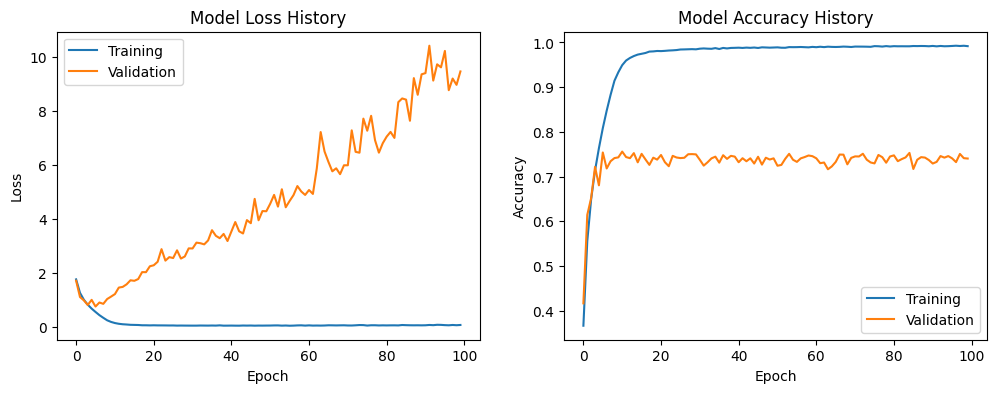

In [36]:
plot_history(history_c, 'model_c')

In [37]:
# evaluate loss and accuracy with testing set
evaluate_model(model_c)

# print optimal epoch from training history
optimal_epoch(history_c)

313/313 [==============================] - 3s 8ms/step - loss: 9.4563 - accuracy: 0.7357
Test loss: 9.456305503845215
Test accu: 0.7357000112533569
Min loss at epoch: 5
Max accu at epoch: 10


(5, 10)

## Adding extra padding to the kernel
- bit of a hack to reduce the decreasing rate of image dimension over network depth
- native image sample resolution is small  
- without padding of 0's will hit negative dimensions in block 3

In [30]:
# 3 block model test
model_d = conv2d_model(blocks=3, padding='same')
model_d.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_45 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

In [43]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_d = model_d.fit(x_partial, y_partial,
                      validation_data=(x_val, y_val),
                      epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                      verbose=1)

Epoch 1/100
313/313 [==============================] - 9s 24ms/step - loss: 1.9186 - accuracy: 0.3092 - val_loss: 1.6476 - val_accuracy: 0.4113
Epoch 2/100
313/313 [==============================] - 8s 24ms/step - loss: 1.3751 - accuracy: 0.5075 - val_loss: 1.1555 - val_accuracy: 0.5862
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 1.0866 - accuracy: 0.6149 - val_loss: 1.0481 - val_accuracy: 0.6259
Epoch 4/100
313/313 [==============================] - 7s 23ms/step - loss: 0.8804 - accuracy: 0.6910 - val_loss: 0.9333 - val_accuracy: 0.6789
Epoch 5/100
313/313 [==============================] - 7s 23ms/step - loss: 0.7345 - accuracy: 0.7424 - val_loss: 1.1891 - val_accuracy: 0.5920
Epoch 6/100
313/313 [==============================] - 7s 23ms/step - loss: 0.6032 - accuracy: 0.7903 - val_loss: 0.8255 - val_accuracy: 0.7253
Epoch 7/100
313/313 [==============================] - 7s 22ms/step - loss: 0.4926 - accuracy: 0.8266 - val_loss: 0.7846 - val_accuracy:

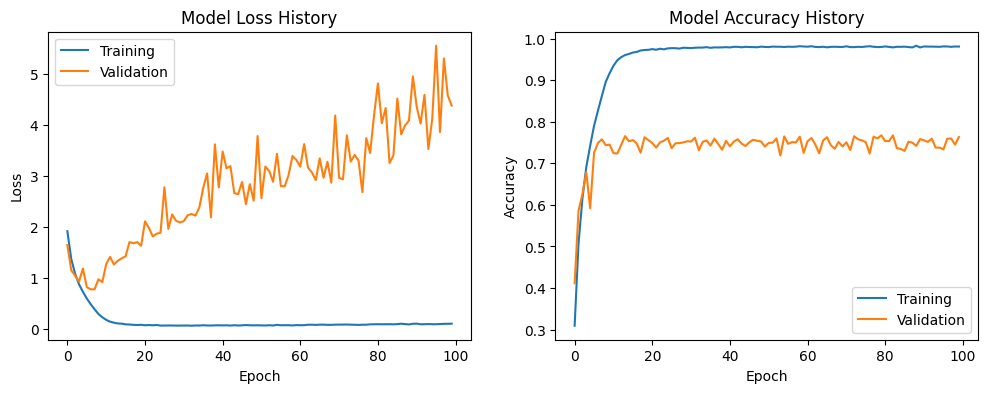

In [44]:
plot_history(history_d, 'model_d')

In [45]:
# evaluate loss and accuracy with testing set
evaluate_model(model_d)

# print optimal epoch from training history
optimal_epoch(history_d)

313/313 [==============================] - 3s 9ms/step - loss: 4.6757 - accuracy: 0.7457
Test loss: 4.6756510734558105
Test accu: 0.7457000613212585
Min loss at epoch: 7
Max accu at epoch: 79


(7, 79)

In [33]:
# model 'f' with doubled layer sizes
model_e = conv2d_model(blocks=3, layer_size=2, padding='same')
model_e.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_61 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                

In [48]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_e = model_e.fit(x_partial, y_partial,
                      validation_data=(x_val, y_val),
                      epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                      verbose=1)

Epoch 1/100
313/313 [==============================] - 13s 38ms/step - loss: 2.1180 - accuracy: 0.2470 - val_loss: 1.6399 - val_accuracy: 0.3969
Epoch 2/100
313/313 [==============================] - 12s 37ms/step - loss: 1.4475 - accuracy: 0.4799 - val_loss: 1.2376 - val_accuracy: 0.5685
Epoch 3/100
313/313 [==============================] - 11s 36ms/step - loss: 1.0892 - accuracy: 0.6166 - val_loss: 1.0546 - val_accuracy: 0.6237
Epoch 4/100
313/313 [==============================] - 11s 36ms/step - loss: 0.8423 - accuracy: 0.7063 - val_loss: 0.8875 - val_accuracy: 0.7005
Epoch 5/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6553 - accuracy: 0.7713 - val_loss: 0.7769 - val_accuracy: 0.7434
Epoch 6/100
313/313 [==============================] - 11s 36ms/step - loss: 0.5095 - accuracy: 0.8229 - val_loss: 0.8502 - val_accuracy: 0.7264
Epoch 7/100
313/313 [==============================] - 11s 36ms/step - loss: 0.3820 - accuracy: 0.8673 - val_loss: 0.7434 - val_ac

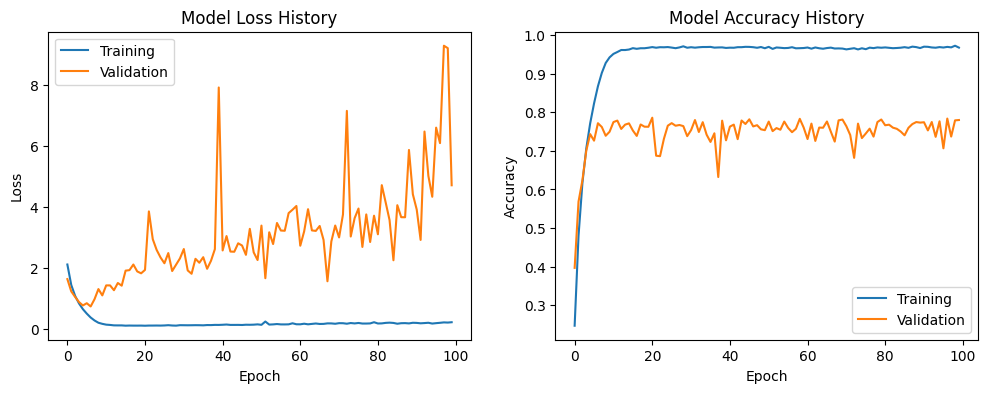

In [49]:
plot_history(history_e, 'model_e')

In [50]:
# evaluate loss and accuracy with testing set
evaluate_model(model_e)

# print optimal epoch from training history
optimal_epoch(history_e)

313/313 [==============================] - 3s 8ms/step - loss: 4.6642 - accuracy: 0.7773
Test loss: 4.6641974449157715
Test accu: 0.7773000597953796
Min loss at epoch: 6
Max accu at epoch: 20


(6, 20)

## Comparison of Different Layer Sizes

In [14]:
# plot histories of models tested so far
histories=[history_a, history_b, history_c, history_d, history_e]
params=['b=1', 'b=2', 'b=2, l_s=2', 'b=3', 'b=3, l_s=2']

plot_history_comparison(histories=histories, 
                        legend_names=params, 
                        title='Layer Size', 
                        lim=17,
                        dotted=[3,5])

NameError: name 'history_a' is not defined

# 7 Regularizing and Tuning Hyperparameters
    Dropout layers
    Different Architectures
    L1 and L2 Regularization
     Demonstrate graphically regularization and taming overfitting

In [13]:
"""
three block model following vgg16
"""
def conv2d_with_reg(blocks=1, dropout=None, optimizer='rmsprop', regularizer=None, layer_size=1):
    model = models.Sequential()

    # block 1
    model.add(layers.Conv2D(32 * layer_size, (3, 3), 
                            activation='relu', 
                            padding='same', 
                            kernel_regularizer=regularizer, 
                            input_shape=X_train[0].shape))
    model.add(layers.Conv2D(32 * layer_size, (3, 3), 
                            activation='relu', 
                            padding='same', 
                            kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    if dropout: model.add(layers.Dropout(dropout))

    # block 2
    if blocks>1:
        model.add(layers.Conv2D(64 * layer_size, (3, 3), 
                                activation='relu', 
                                padding='same', 
                                kernel_regularizer=regularizer))
        model.add(layers.Conv2D(64 * layer_size, (3, 3), 
                                activation='relu', 
                                padding='same', 
                                kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if dropout: model.add(layers.Dropout(dropout))

    # block 3
    if blocks>2:
        model.add(layers.Conv2D(128 * layer_size, (3, 3), 
                                activation='relu', 
                                padding='same', 
                                kernel_regularizer=regularizer))
        model.add(layers.Conv2D(128 * layer_size, (3, 3), 
                                activation='relu', 
                                padding='same', 
                                kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if dropout: model.add(layers.Dropout(dropout))

    # head
    model.add(layers.Flatten())
    model.add(layers.Dense(64 * np.power(2,blocks-1) * layer_size, 
                           activation='relu',
                           kernel_regularizer=regularizer))
    if dropout: model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    
    # hyperparameter functions
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

Dropout Testing

In [15]:
regularizer=regularizers.l2(0.001)

model_f = conv2d_with_reg(blocks=3, dropout=0.25, optimizer='adam', regularizer=regularizer)
model_f.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                      

In [14]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_f = model_f.fit(x_partial, y_partial,
                      validation_data=(x_val, y_val),
                      epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                      verbose=1)

Epoch 1/100
313/313 [==============================] - 10s 28ms/step - loss: 1.9415 - accuracy: 0.3011 - val_loss: 1.5405 - val_accuracy: 0.4450
Epoch 2/100
313/313 [==============================] - 8s 27ms/step - loss: 1.4538 - accuracy: 0.4876 - val_loss: 1.3098 - val_accuracy: 0.5445
Epoch 3/100
313/313 [==============================] - 8s 27ms/step - loss: 1.2670 - accuracy: 0.5606 - val_loss: 1.1540 - val_accuracy: 0.5933
Epoch 4/100
313/313 [==============================] - 8s 27ms/step - loss: 1.1388 - accuracy: 0.6116 - val_loss: 1.0183 - val_accuracy: 0.6537
Epoch 5/100
313/313 [==============================] - 8s 26ms/step - loss: 1.0297 - accuracy: 0.6535 - val_loss: 0.9178 - val_accuracy: 0.6904
Epoch 6/100
313/313 [==============================] - 8s 26ms/step - loss: 0.9516 - accuracy: 0.6847 - val_loss: 0.8710 - val_accuracy: 0.7096
Epoch 7/100
313/313 [==============================] - 9s 28ms/step - loss: 0.8961 - accuracy: 0.7029 - val_loss: 0.8007 - val_accuracy

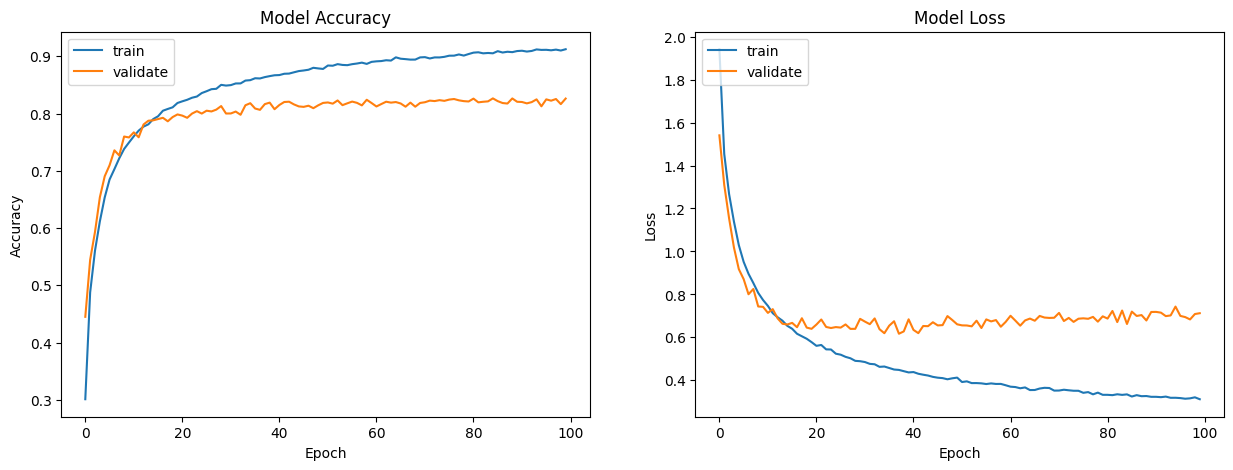

In [17]:
plot_history(history_f)

In [18]:
print(np.argmin(history_f.history['val_loss']))
loss, acc = model_f.evaluate(x_test, prep_encoder(y_test), verbose=1)
print(f'Test loss: {loss}')
print(f'Test accuracy: {acc}')

37
313/313 [==============================] - 3s 8ms/step - loss: 0.7278 - accuracy: 0.8289
Test loss: 0.7278416752815247
Test accuracy: 0.8289000391960144


In [16]:
N_EPOCHS = 100
BATCH_SIZE = 256


history_g = model_f.fit(x_partial, y_partial,
                      validation_data=(x_val, y_val),
                      epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                      verbose=1)

Epoch 1/100
157/157 [==============================] - 6s 33ms/step - loss: 2.1562 - accuracy: 0.2296 - val_loss: 1.8189 - val_accuracy: 0.3416
Epoch 2/100
157/157 [==============================] - 5s 30ms/step - loss: 1.6377 - accuracy: 0.4103 - val_loss: 1.4659 - val_accuracy: 0.4765
Epoch 3/100
157/157 [==============================] - 5s 30ms/step - loss: 1.4054 - accuracy: 0.5038 - val_loss: 1.3122 - val_accuracy: 0.5472
Epoch 4/100
157/157 [==============================] - 5s 31ms/step - loss: 1.2556 - accuracy: 0.5631 - val_loss: 1.1433 - val_accuracy: 0.6025
Epoch 5/100
157/157 [==============================] - 5s 31ms/step - loss: 1.1514 - accuracy: 0.6056 - val_loss: 1.0900 - val_accuracy: 0.6236
Epoch 6/100
157/157 [==============================] - 5s 30ms/step - loss: 1.0630 - accuracy: 0.6370 - val_loss: 0.9975 - val_accuracy: 0.6650
Epoch 7/100
157/157 [==============================] - 5s 31ms/step - loss: 0.9976 - accuracy: 0.6636 - val_loss: 0.9125 - val_accuracy:

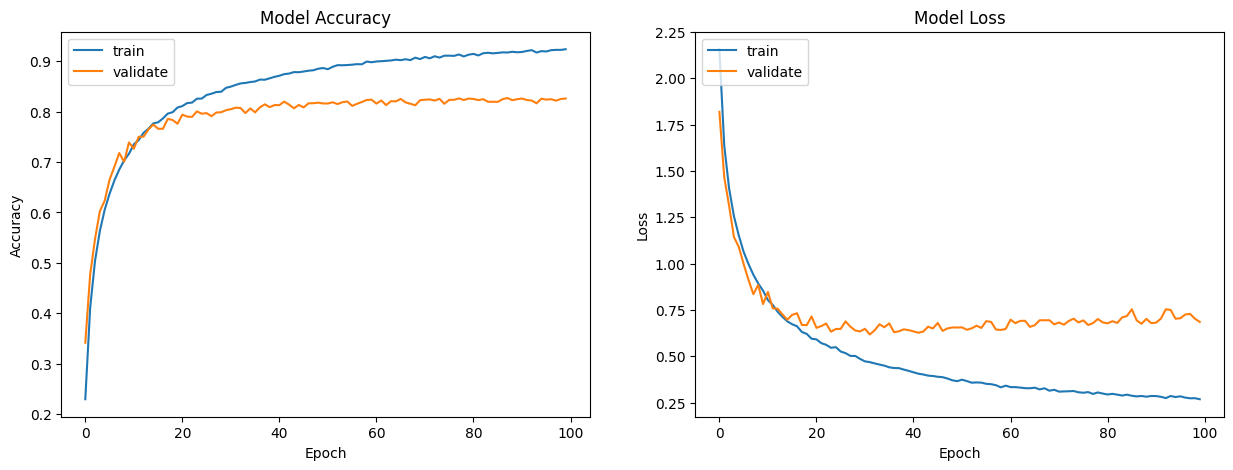

31


In [17]:
plot_history(history_g)
print(np.argmin(history_g.history['val_loss']))


In [16]:
N_EPOCHS = 100
BATCH_SIZE = 512


history_h = model_f.fit(x_partial, y_partial,
                      validation_data=(x_val, y_val),
                      epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                      verbose=1)

Epoch 1/100
79/79 [==============================] - 6s 57ms/step - loss: 2.2506 - accuracy: 0.2077 - val_loss: 1.8910 - val_accuracy: 0.3158
Epoch 2/100
79/79 [==============================] - 3s 44ms/step - loss: 1.7922 - accuracy: 0.3606 - val_loss: 1.5874 - val_accuracy: 0.4361
Epoch 3/100
79/79 [==============================] - 4s 45ms/step - loss: 1.5804 - accuracy: 0.4353 - val_loss: 1.4566 - val_accuracy: 0.4823
Epoch 4/100
79/79 [==============================] - 4s 48ms/step - loss: 1.4465 - accuracy: 0.4865 - val_loss: 1.3603 - val_accuracy: 0.5182
Epoch 5/100
79/79 [==============================] - 4s 45ms/step - loss: 1.3377 - accuracy: 0.5350 - val_loss: 1.3891 - val_accuracy: 0.5226
Epoch 6/100
79/79 [==============================] - 3s 44ms/step - loss: 1.2615 - accuracy: 0.5642 - val_loss: 1.1486 - val_accuracy: 0.6052
Epoch 7/100
79/79 [==============================] - 4s 45ms/step - loss: 1.1882 - accuracy: 0.5898 - val_loss: 1.1068 - val_accuracy: 0.6160
Epoch 

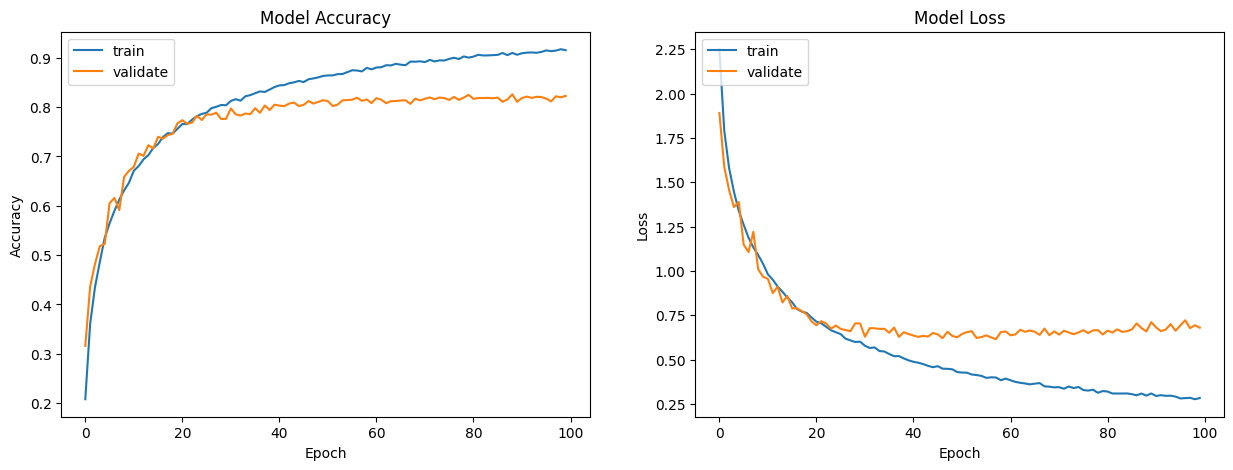

57


In [17]:
plot_history(history_h)
print(np.argmin(history_h.history['val_loss']))

In [15]:
def conv2d_with_reg(blocks=1, dropout=None, optimizer='rmsprop', regularizer=None):
    model = models.Sequential()

    # block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, input_shape=X_train[0].shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    if dropout: model.add(layers.Dropout(dropout))

    # block 2
    if blocks>1:
        model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer))
        model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if dropout: model.add(layers.Dropout(dropout))

    # block 3
    if blocks>2:
        model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer))
        model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        if dropout: model.add(layers.Dropout(dropout))

    # head
    model.add(layers.Flatten())
    model.add(layers.Dense(64 * np.power(2,blocks-1), activation='relu',kernel_regularizer=regularizer))
    if dropout: model.add(layers.Dropout(dropout))
    model.add(layers.Dense(10, activation='softmax'))
    
    # hyperparameter functions
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [116]:
regularizer = regularizers.l2(0.0001)
optimizer = optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

model_i = conv2d_with_reg(blocks=2, dropout=0.5, optimizer=optimizer, regularizer=regularizer)
model_i.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_47 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

In [117]:
N_EPOCHS = 100
BATCH_SIZE = 128


history_i = model_i.fit(x_partial, y_partial,
                      validation_data=(x_val, y_val),
                      epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                      verbose=1)

Epoch 1/100


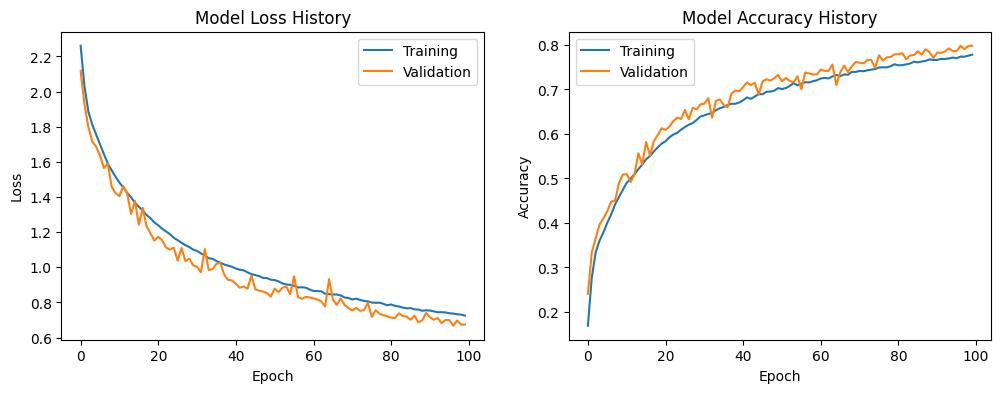

In [ ]:
plot_history(history_i)

In [ ]:
print(np.argmin(history_i.history['val_loss']))
loss, acc = model_i.evaluate(x_test, prep_encoder(y_test), verbose=1)
print(f'Test loss: {loss}')
print(f'Test accuracy: {acc}')

96
313/313 [==============================] - 3s 9ms/step - loss: 0.6885 - accuracy: 0.7935
Test loss: 0.6884514093399048
Test accuracy: 0.7935000658035278


In [ ]:
y_pred = model_i.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

313/313 [==============================] - 2s 7ms/step


Number of incorrect predictions: 2065/10000
Prediction accuracy: 0.7935
10 sample plot


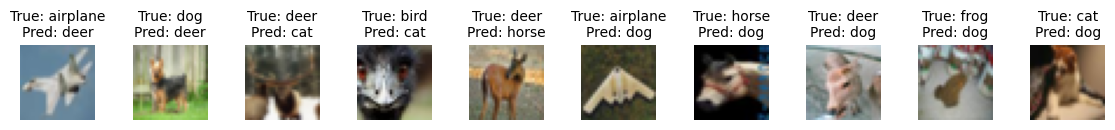

In [ ]:
errors = np.sum(y_pred != y_test)
errors_index = np.where(y_pred != y_test)[0]
test_samples = len(y_pred)

print(f'Number of incorrect predictions: {errors}/{test_samples}')
print(f'Prediction accuracy: {1-errors/test_samples}')

plot_multi_sample(X_test[errors_index][:10], y_test[errors_index][:10].ravel(), y_pred[errors_index][:10])

- l2 regularization on every layer helps validation loss, regularizer=regularizers.l2(0.001) is too high, model is underfitting
- 0.3-0.5 dropout seems to be the sweet spot
- train final model on longer epochs
- 2 vs 3 blocks
- high dropout of 0.5 produces good accuracy and low loss, perhaps due to low quality of images (batch_size=128)

# References
https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

https://keras.io/api/layers/convolution_layers/convolution2d/

https://stackoverflow.com/questions/17888593/display-sequence-of-images-using-matplotlibmatpl

https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf alexnet

https://arxiv.org/pdf/1409.1556.pdf vgg16



#https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer

#https://github.com/hudsonmendes/uolondon-cm3015-mlnn/blob/main/final/report.ipynb

#### Misc GPU Testing

In [ ]:
# native Windows tensorflow=2.10
!nvidia-smi

Tue Sep 12 23:12:20 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080      WDDM  | 00000000:01:00.0  On |                  N/A |
| 41%   59C    P0              64W / 172W |   7523MiB /  8192MiB |     22%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Look for GPU
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
